Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
Dataset prepared successfully!
Training started...
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 413s 108ms/step - accuracy: 0.9918 - loss: 0.0284 - val_accuracy: 0.9983 - val_loss: 0.0041
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


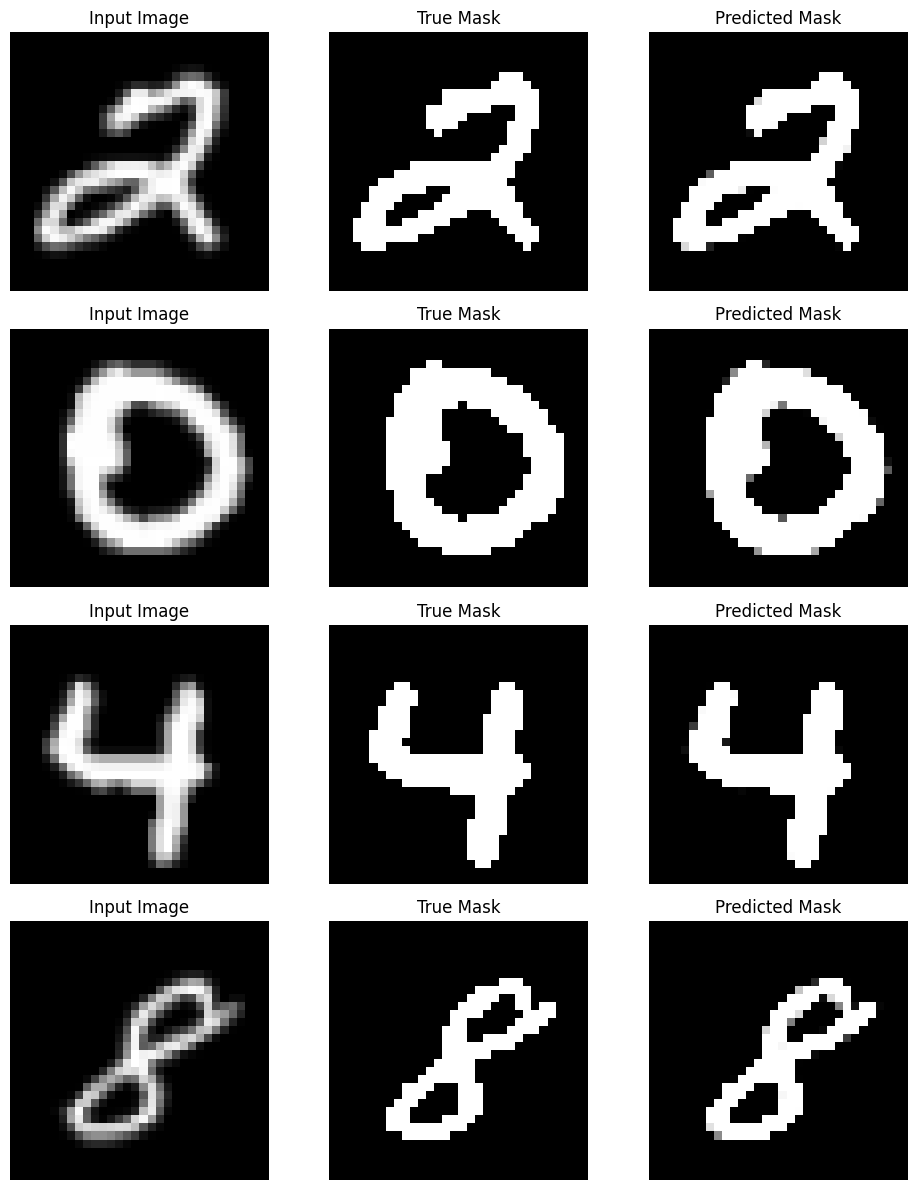

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load the MNIST dataset
dataset, info = tfds.load("mnist", with_info=True, as_supervised=True)

# Preprocessing function with a lower threshold for segmentation
def normalize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (32, 32)) / 255.0
    input_mask = tf.where(input_image > 0.3, 1, 0)  # Lower threshold
    return input_image, input_mask

def load_image(image, label):
    return normalize(tf.cast(image, tf.float32), tf.cast(image, tf.uint8))

# Prepare dataset with batch size 16 for more samples per batch
train_data = dataset['train'].map(load_image).shuffle(1000).batch(16)
test_data = dataset['test'].map(load_image).batch(16)

print("Dataset prepared successfully!")

# Define CNN model with Batch Normalization
def simple_cnn():
    inputs = tf.keras.layers.Input(shape=(32, 32, 1))

    conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)

    # Decoder
    up4 = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(conv3)
    up4 = tf.keras.layers.BatchNormalization()(up4)
    concat4 = tf.keras.layers.Concatenate()([up4, conv2])

    up5 = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(concat4)
    up5 = tf.keras.layers.BatchNormalization()(up5)
    concat5 = tf.keras.layers.Concatenate()([up5, conv1])

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(concat5)

    model = tf.keras.Model(inputs, outputs)
    return model

# Compile model
model = simple_cnn()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train for only 1 epoch
print("Training started...")
model.fit(train_data, epochs=1, validation_data=test_data)  # Only 1 epoch

# Predict and visualize multiple samples
def display_samples(dataset):
    for images, masks in dataset.take(1):
        pred_masks = model.predict(images)
        fig, axes = plt.subplots(4, 3, figsize=(10, 12))  # Display 4 samples

        for i in range(4):  # Show 4 test images
            axes[i, 0].imshow(images[i, :, :, 0], cmap='gray')
            axes[i, 0].set_title("Input Image")
            axes[i, 0].axis("off")

            axes[i, 1].imshow(masks[i, :, :, 0], cmap='gray')
            axes[i, 1].set_title("True Mask")
            axes[i, 1].axis("off")

            axes[i, 2].imshow(pred_masks[i, :, :, 0], cmap='gray')
            axes[i, 2].set_title("Predicted Mask")
            axes[i, 2].axis("off")

        plt.tight_layout()
        plt.show()
        break

# Visualize results
display_samples(test_data)